In [200]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
import numpy as np

In [202]:
image = np.random.randn(30, 32, 32)
filters = np.random.randn(32,image.shape[0], 3,3) * 0.1

In [203]:
patch = image[:, :3, :3]
patch.shape

(30, 3, 3)

In [204]:
filters[0].shape

(30, 3, 3)

In [205]:
conv  = filters[0] * patch 
conv.shape

(30, 3, 3)

In [206]:
np.sum(conv)

-0.6419162977240856

In [207]:
np.linalg.norm([[1,2],[2,3]])

4.242640687119285

In [208]:
np.sqrt(np.sum(np.array([[1,2],[2,3]])**2))

4.242640687119285

# Steps

- Train loop
    - Forward
        - Conv
        - Relu
        - Conv
        - Relu
        - Dense
        - Softmax
        - Cross entropy
    
    Backprop the gradients for all the layers

    Test the code for MNIST

In [209]:
import mnist

In [210]:
mnist.init()

Download complete.
Save complete.


In [211]:
x_train, y_train, x_test, y_test = mnist.load()

In [212]:
x_train.shape

(60000, 784)

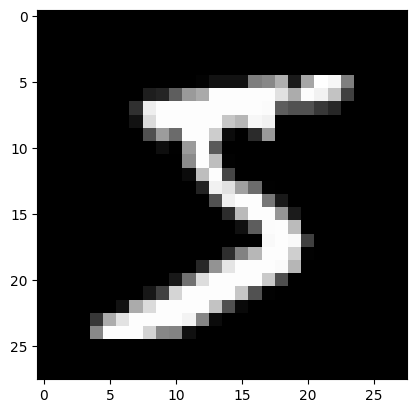

In [213]:
import matplotlib.pyplot as plt

img = x_train[0,:].reshape(28,28) # First image in the training set.
plt.imshow(img,cmap='gray')
plt.show() # Show the image

In [214]:
from layer import Layer

In [215]:
200 * 0.1

20.0

In [216]:
class ReluLayer(Layer):
    def __init__(self, layer_name):
        super().__init__(layer_name)
        self.cached_output = None

    def forward(self, input_activations):
        self.cached_output = np.maximum(0, input_activations)
        return self.cached_output

    def backward(self, global_gradients, lr):
        local_grad = np.array(global_gradients, copy=True)
        local_grad[self.cached_output <= 0] = 0 
        return local_grad

In [217]:
class DenseLayer(Layer):
    def __init__(self, layer_name, input_nodes, output_nodes, debug = False):
        super().__init__(layer_name)
        self.debug = debug
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes

        '''
        Gloro/Xavier initialization for weights for faster convergence
        https://pyimagesearch.com/2021/05/06/understanding-weight-initialization-for-neural-networks/
        '''
        limit = np.sqrt(2 / float(input_nodes + output_nodes))
        self.weights = np.random.normal(0.0, limit, size = (input_nodes, output_nodes))

        ''' 
        No initialization is required for bias,
        https://cs231n.github.io/neural-networks-2/#:~:text=Initializing%20the%20biases
        '''
        self.bias = np.zeros(output_nodes)

        #we need to cache the input and output from this layer for the purpose of backprop
        self.cached_input = None
        self.cached_output = None

    # overriden
    def forward(self, input_activations):
        '''

        @param input_activations - Output of previous layer
        @return softmax of logits

        Dense layer forward prop
        1. Flatten the input
        2. Dot product with weights and add the bias
        3. Cache the input and logits for backpop
        4. Apply softmax on logits and return it
        '''

        shape = input_activations.shape
        layer_input = input_activations.ravel().reshape(shape[0], -1)
        layer_logits = np.dot(layer_input, self.weights) + self.bias

        self.cached_input = layer_input
        self.cached_output = layer_logits
        if self.debug:
            print(f"Cached output {self.cached_output}, ip shape {layer_input.shape}, op shape {layer_logits.shape}")
        return self.cached_output


    #overriden
    def backward(self, global_gradient, current_lr):
        '''
        @param global_gradient, gradients from the previous layer
        @param current_lr 


        @returns The gradient of Loss w.r.t to the input to this layer
        i.e the input_activations recieved during forward pass.

        Dense layer backward prop
        1. Calculate the gradients w.r.t to the weights
        2. Calculate the gradients w.r.t to the received activations
        and return it for usage in other previous layers.

        '''
        output_grad  = global_gradient
        

        assert output_grad.shape[1] == self.weights.T.shape[0]
        assert self.cached_input.T.shape[1] == output_grad.shape[0]

        input_grad = np.dot(output_grad, self.weights.T)
        weight_grad = np.dot(self.cached_input.T, output_grad)
        
        if self.debug:
            print(f"weights shape {self.weights.shape}, weight grad shape {weight_grad.shape}, input_shape {self.cached_input.shape}, input_grad shape {input_grad.shape}, ")

        self.weights -= current_lr * weight_grad
        self.bias -= current_lr * np.sum(output_grad, axis=1)

        return input_grad
    



In [218]:
dense_1 = DenseLayer("Dense_1",784, 10)

In [219]:
dense_1.forward(np.random.randn(1,784)).shape

(1, 10)

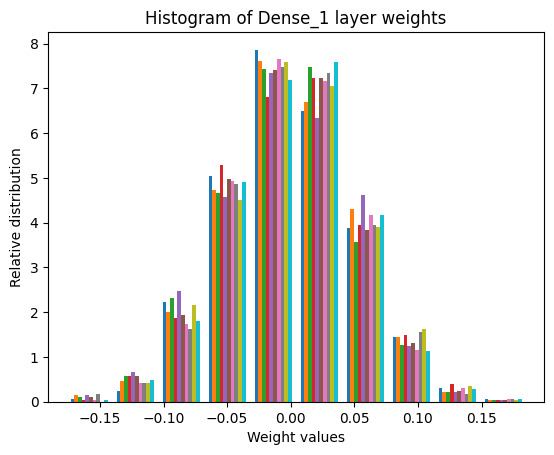

In [220]:
import utils
utils.plot_histogram(dense_1.layer_name, dense_1.weights)

In [221]:
28*28

784

### Model

In [222]:
from activations import Softmax_Categorical_CrossEntropy

In [223]:
dense_1 = DenseLayer("Dense_1", 784, 14)
relu_1 = ReluLayer("relu_1")
dense_2 = DenseLayer("Dense_2", 14, 10)

softmax_loss = Softmax_Categorical_CrossEntropy("Softmax_CCE_1")

In [224]:
y = dense_1.forward(img.reshape(1, 28, 28))
relu_y = relu_1.forward(y)
y = dense_2.forward(relu_y)

true_labels = y_train[0].reshape(1,1)
loss = softmax_loss.forward(y, true_labels)
print(f"loss {loss}, ypredicted {y}")

# gradients /= samples

global_grad = softmax_loss.backward(softmax_loss.cached_output, true_labels)
print(global_grad.shape)

global_grad = dense_2.backward(global_grad, 1e-6)
print(global_grad.shape)
global_grad = relu_1.backward(global_grad, 1e-6)
global_grad = dense_1.backward(global_grad, 1e-06)

loss [[0.56799209]], ypredicted [[-101.19999662  -54.94671767   51.83343275   45.95575211   -2.97518233
   136.95568672  -67.89317767   30.58610947  136.68744132  -52.74373757]]
(1, 10)
(1, 14)


In [225]:
relu_y

array([[  0.        ,   0.        ,  13.02058054,   0.        ,
         73.04029884,  98.28191386, 180.76912898,   0.        ,
        147.98560451,   0.        , 105.66986401,  25.29644812,
          0.        , 138.45178551]])

In [226]:
relu_y <= 0

array([[ True,  True, False,  True, False, False, False,  True, False,
         True, False, False,  True, False]])

In [227]:
global_grad[relu_y <= 0] = 0

IndexError: boolean index did not match indexed array along dimension 1; dimension is 784 but corresponding boolean dimension is 14

In [ ]:
print(global_grad)
global_grad[relu_y <= 0] = 0
print(global_grad)

[[0.52752916 0.         0.         0.         0.         0.
  0.         0.         0.18805263 0.         0.44912853 0.
  0.09432481 0.        ]]
[[0.52752916 0.         0.         0.         0.         0.
  0.         0.         0.18805263 0.         0.44912853 0.
  0.09432481 0.        ]]


In [ ]:
global_grad < 0

array([[False,  True,  True, False, False, False, False,  True, False,
         True, False, False, False,  True]])

In [ ]:
np.expand_dims(global_grad, 0).shape

(1, 1, 784)

In [ ]:
true_labels

array([[5]], dtype=uint8)

In [ ]:
true_labels.shape

(1, 1)

In [ ]:
global_grad.shape

(1, 784)

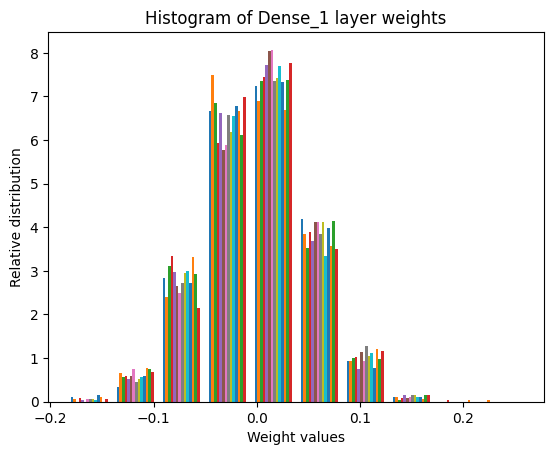

In [ ]:
utils.plot_histogram("Dense_1", dense_1.weights)

### Sequential

In [314]:
from model import Sequential

np.random.seed(42)

dense_1 = DenseLayer("Dense_1", 784, 14)
relu_1 = ReluLayer("relu_1")
dense_2 = DenseLayer("Dense_2", 14, 10)

layers = [dense_1, relu_1, dense_2]
sequential_model = Sequential(layers)

In [315]:
x_train.shape

(60000, 784)

In [316]:
x_preprocessed = x_train[:40000]
y_preprocessed = y_train[:40000]

x_preprocessed = utils.minmax_normalize(x_preprocessed)

In [317]:
x_val_preprocessed = x_train[40000: 60000]
y_val_preprocessed = y_train[40000: 60000]

x_val_preprocessed = utils.minmax_normalize(x_val_preprocessed)

In [318]:
y_val_preprocessed

array([7, 7, 0, ..., 5, 6, 8], dtype=uint8)

In [319]:
sequential_model.train([x_preprocessed, y_preprocessed], [x_val_preprocessed, y_val_preprocessed], 20, 1, True)

----------
Epoch 1, Time 17.732226371765137 seconds
Train Accuracy 92.8075, Validation accuracy 92.5
Train Loss [9777.49610318], Validation loss [0.25957473]
----------
----------
Epoch 2, Time 17.646872997283936 seconds
Train Accuracy 93.465, Validation accuracy 93.685
Train Loss [8863.84557316], Validation loss [0.22793467]
----------
----------
Epoch 3, Time 19.009684801101685 seconds
Train Accuracy 93.795, Validation accuracy 93.07
Train Loss [8435.89419225], Validation loss [0.24474643]
----------
----------
Epoch 4, Time 17.602104663848877 seconds
Train Accuracy 94.11749999999999, Validation accuracy 92.65
Train Loss [8053.74941335], Validation loss [0.2538249]
----------
----------
Epoch 5, Time 23.71367907524109 seconds
Train Accuracy 94.44500000000001, Validation accuracy 93.13
Train Loss [7620.32231117], Validation loss [0.25059896]
----------
----------
Epoch 6, Time 30.281090021133423 seconds
Train Accuracy 94.415, Validation accuracy 92.63
Train Loss [7477.71516087], Valid

In [312]:
x_test_preprocessed = x_test
y_test_preprocessed = y_test

x_test_preprocessed = utils.minmax_normalize(x_test_preprocessed)

In [313]:
sequential_model.test([x_test_preprocessed, y_test_preprocessed])

(91.72, array([0.36081928]))

3

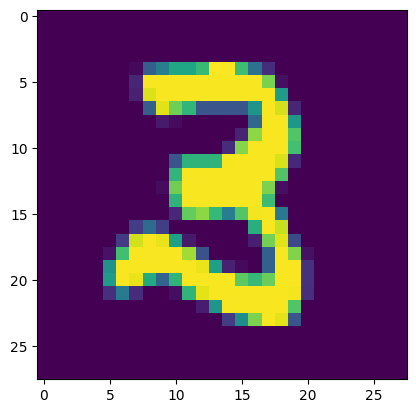

In [301]:
test_image = utils.minmax_normalize(x_test[np.random.randint(0,10000)])
plt.imshow(test_image.reshape(28, 28))

np.argmax(sequential_model._forward(np.expand_dims(test_image, 0)))

In [302]:
x_train.shape

(60000, 784)

In [303]:
permuted_idx = np.random.permutation(range(x_train.shape[0]))
x_permuted = x_train[permuted_idx]
y_permuted = y_train[permuted_idx]

0

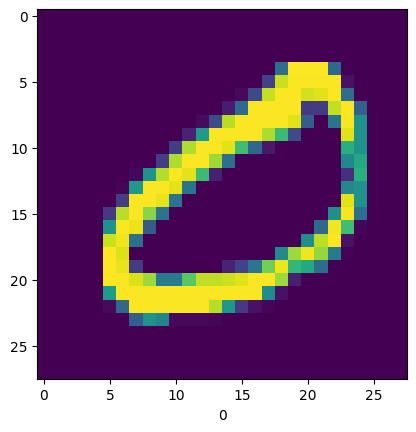

In [304]:
idx = np.random.randint(0,10000)
test_image = utils.minmax_normalize(x_permuted[idx])

plt.imshow(test_image.reshape(28, 28))
plt.xlabel(y_permuted[idx])

np.argmax(sequential_model._forward(np.expand_dims(test_image, 0)))

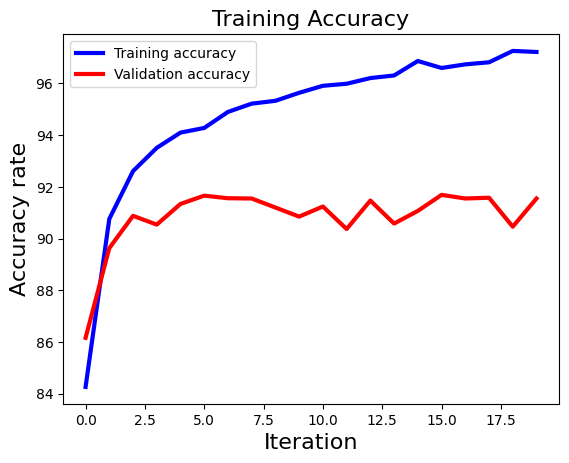

In [305]:
utils.plot_accuracy_curve(sequential_model.train_accuracy, sequential_model.validation_accuracy)

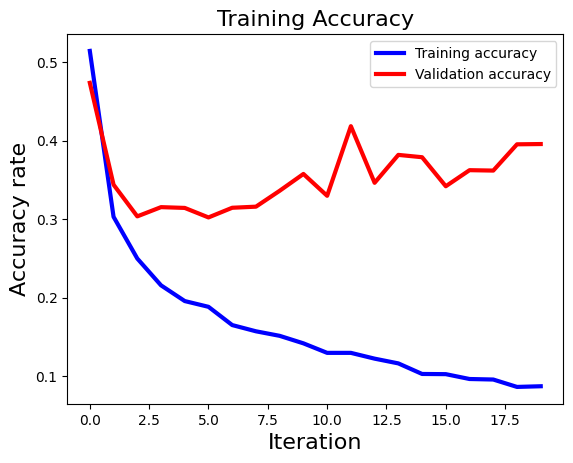

In [306]:
utils.plot_accuracy_curve(sequential_model.train_loss, sequential_model.validation_loss)

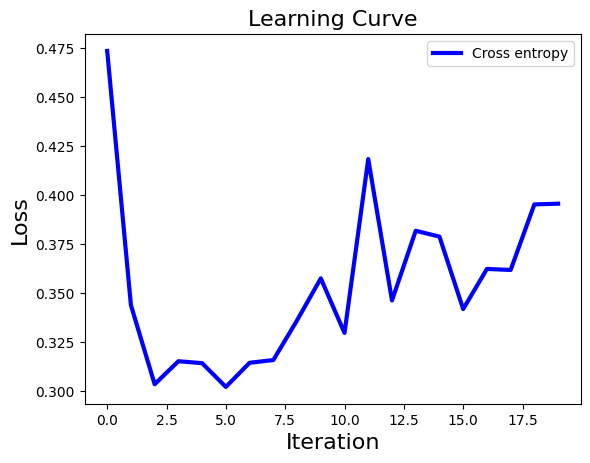

In [307]:
utils.plot_learning_curve(sequential_model.validation_loss)

In [ ]:
# def generate_batches(x: np.array, y: np.array, batch_size: int):
#     """
#     :param x - features array with (n, ...) shape
#     :param y - one hot ground truth array with (n, k) shape
#     :batch_size - number of elements in single batch
#     ----------------------------------------------------------------------------
#     n - number of examples in data set
#     k - number of classes
#     """
#     for i in range(0, x.shape[0], batch_size):
#         yield (
#             x.take(indices=range(i, min(i + batch_size, x.shape[0])), axis=0),
#             y.take(indices=range(i, min(i + batch_size, y.shape[0])), axis=0),
#         )


In [ ]:
x_train.shape

(60000, 784)

In [ ]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [ ]:
y_t = np.expand_dims(y_train, 1)

In [ ]:
y_t.shape

(60000, 1)

In [ ]:
y_train.shape

(60000,)

In [ ]:
# for x, y in generate_batches(x_train, y_t, 1):
#     print(x.shape, y.shape)